In [1]:
import tensorflow as tf
import numpy as np
import random
from collections import deque
import osmnx as ox
import networkx as nx
import folium
from matplotlib import cm
import matplotlib.colors as mcolors
import osmnx as ox
from geopy.geocoders import Nominatim
import time
import osmnx as ox
import networkx as nx
import pandas as pd
import os
from geopy.geocoders import Nominatim
import pickle
from math import radians, sin, cos, sqrt, atan2 

DATA PREPROCESSING

In [2]:
# STEP 1: MENGAMBIL DATA JALAN dari OSM

# Daftar kota yang akan diproses
cities = ["Surabaya, Indonesia", "Malang, Indonesia", "Kediri, Indonesia", "Sidoarjo, Indonesia", "Gresik, Indonesia"]
data_dir = "../data"  # lokasi penyimpanan file .pkl

for city_name in cities:
    safe_name = city_name.split(",")[0].replace(" ", "_").lower()
    filepath = f"{data_dir}/road_graph_{safe_name}.pkl"
    
    if os.path.exists(filepath):
        print(f"✅ Data jalan {city_name} sudah tersedia.")
    else:
        print(f"📥 Mengambil data jalan dari OSM: {city_name}...")
        
        # Ambil jaringan jalan yang bisa dilalui mobil
        G = ox.graph_from_place(city_name, network_type="drive", simplify=True)
        
        # Simpan ke file .pkl
        nx.write_gpickle(G, filepath)
        print(f"💾 Data jalan {city_name} disimpan sebagai {filepath}")

✅ Data jalan Surabaya, Indonesia sudah tersedia.
✅ Data jalan Malang, Indonesia sudah tersedia.
✅ Data jalan Kediri, Indonesia sudah tersedia.
✅ Data jalan Sidoarjo, Indonesia sudah tersedia.
✅ Data jalan Gresik, Indonesia sudah tersedia.


In [3]:
# STEP 2: MEMUAT DATA SPKLU dari CSV

spklu_path = f"{data_dir}/spklu_dataset.csv"
spklu_df = pd.read_csv(spklu_path)

print("📊 Contoh data SPKLU:")
print(f"📄 Jumlah SPKLU dalam dataset: {len(spklu_df)}")

display(spklu_df.head())

📊 Contoh data SPKLU:
📄 Jumlah SPKLU dalam dataset: 10


,Nama SPKLU,Alamat,Latitude,Longitude,Jenis Konektor & Daya
0,SPKLU Gedung Pemkot Surabaya,"PPRX+R52 Ketabang, Surabaya, East Java",-7.257996,112.747887,AC TYPE 2 - 22KW
1,SPKLU Balai Kota Surabaya,"PPRX+R52 Ketabang, Surabaya, East Java",-7.257996,112.747887,AC TYPE 2 - 22KW
2,SPKLU WTC Surabaya Mall,"PPPX+X7C Embong Kaliasin, Surabaya, East Java",-7.262561,112.748145,"AC TYPE - 22KW, CCS 2 - 60KW DC, CHAdeMO - 60K..."
3,SPKLU PLN UID Jawa Timur,"PPMV+P77 Embong Kaliasin, Surabaya, East Java",-7.265702,112.743163,"AC TYPE - 7KW, CCS 2 - 100KW DC"
4,SPKLU Emergency Mobile,"PPMV+J63 Embong Kaliasin, Surabaya, East Java",-7.265988,112.743054,"AC TYPE - 22KW, CCS 2 - 30KW DC"


In [4]:
# STEP 3: Tambahkan Bobot Jarak dan Energi ke Graf Jalan

def calculate_energy(length_km, inclination):
    base_consumption = 0.2  # konsumsi energi rata-rata mobil listrik di jalan datar
    elevation_factor = 0.05  # penambahan konsumsi energi karena tanjakan
    return base_consumption * length_km + elevation_factor * (length_km * inclination)

print("\n⚙️ Mulai proses pemberian bobot ke graf jalan...")

for city_name in cities:
    safe_name = city_name.split(",")[0].replace(" ", "_").lower()
    graph_path = f"{data_dir}/road_graph_{safe_name}.pkl"
    
    if not os.path.exists(graph_path):
        print(f"❌ Tidak ada graf jalan untuk {city_name}. Lewati.")
        continue

    try:
        # Menggunakan pickle untuk membaca file graf jalan
        with open(graph_path, 'rb') as f:
            G = pickle.load(f)
    except Exception as e:
        print(f"❌ Error saat memuat graf jalan {city_name}: {e}")
        continue

    # Tambahkan bobot pada setiap edge (jalan)
    for u, v, data in G.edges(data=True):
        length_km = data.get("length", 1) / 1000  # Pastikan nilai default adalah 1 jika tidak ada data 'length'
        inclination = data.get("grade", 0)

        # Menangani kasus jika tidak ada data untuk 'length' atau 'grade'
        if length_km is None:
            length_km = 1  # Set default jika tidak ada panjang
        if inclination is None:
            inclination = 0  # Set default jika tidak ada kemiringan

        data["distance"] = length_km
        data["energy"] = calculate_energy(length_km, inclination)

    weighted_path = f"{data_dir}/road_graph_weighted_{safe_name}.pkl"
    try:
        # Menggunakan pickle untuk menyimpan file graf jalan yang sudah diberi bobot
        with open(weighted_path, 'wb') as f:
            pickle.dump(G, f)
        print(f"💾 Bobot distance & energy disimpan: {weighted_path}")
    except Exception as e:
        print(f"❌ Gagal menyimpan graf dengan bobot untuk {city_name}: {e}")

print("✅ Semua graf diperbarui dengan bobot konsumsi energi.")



⚙️ Mulai proses pemberian bobot ke graf jalan...
💾 Bobot distance & energy disimpan: ../data/road_graph_weighted_surabaya.pkl
💾 Bobot distance & energy disimpan: ../data/road_graph_weighted_malang.pkl
💾 Bobot distance & energy disimpan: ../data/road_graph_weighted_kediri.pkl
💾 Bobot distance & energy disimpan: ../data/road_graph_weighted_sidoarjo.pkl
💾 Bobot distance & energy disimpan: ../data/road_graph_weighted_gresik.pkl
✅ Semua graf diperbarui dengan bobot konsumsi energi.


In [5]:
# STEP 4: Menambahkan SPKLU ke Graf Jalan

print("\n📌 Menambahkan SPKLU ke dalam graf jalan...\n")

spklu_nodes_per_city = {}  

for city_name in cities:
    safe_name = city_name.split(",")[0].replace(" ", "_").lower()
    graph_path = f"{data_dir}/road_graph_weighted_{safe_name}.pkl"

    if not os.path.exists(graph_path):
        print(f"⚠️ Lewat: Data graf {city_name} belum ada.")
        continue

  # Membaca graf menggunakan pickle
    try:
        with open(graph_path, 'rb') as f:
            G = pickle.load(f)
    except Exception as e:
        print(f"❌ Gagal memuat graf untuk {city_name}: {e}")
        continue


    city_name_only = city_name.split(",")[0]
    city_spklu = spklu_df[spklu_df["Alamat"].str.contains(city_name_only, case=False, na=False)]

    spklu_nodes = {}
    for _, row in city_spklu.iterrows():
        try:
            node_id = ox.nearest_nodes(G, row["Longitude"], row["Latitude"])

            raw_konektor = row["Jenis Konektor & Daya"]
            konektor_list = [
                k.strip().split("-")[0].strip().replace(" ", "").upper()
                for k in raw_konektor.split(",")
            ]

            spklu_nodes[node_id] = {
                "coords": (row["Latitude"], row["Longitude"]),
                "available_connectors": konektor_list
            }
            
            G.nodes[node_id]["is_spklu"] = True

        except Exception as e:
            print(f"⚠️ Error mencari node terdekat untuk SPKLU di {city_name}: {e}")

    spklu_nodes_per_city[city_name_only] = spklu_nodes
    print(f"✅ {len(spklu_nodes)} SPKLU berhasil dimapping ke graf {city_name_only}.")
    
    # Simpan ulang graf dengan SPKLU info 
    try:
        with open(graph_path, 'wb') as f:
            pickle.dump(G, f)
        print(f"💾 Graf dengan SPKLU disimpan kembali untuk {city_name_only}.")
    except Exception as e:
        print(f"❌ Gagal menyimpan graf dengan SPKLU untuk {city_name_only}: {e}")


📌 Menambahkan SPKLU ke dalam graf jalan...

✅ 9 SPKLU berhasil dimapping ke graf Surabaya.
💾 Graf dengan SPKLU disimpan kembali untuk Surabaya.
✅ 0 SPKLU berhasil dimapping ke graf Malang.
💾 Graf dengan SPKLU disimpan kembali untuk Malang.
✅ 0 SPKLU berhasil dimapping ke graf Kediri.
💾 Graf dengan SPKLU disimpan kembali untuk Kediri.
✅ 0 SPKLU berhasil dimapping ke graf Sidoarjo.
💾 Graf dengan SPKLU disimpan kembali untuk Sidoarjo.
✅ 0 SPKLU berhasil dimapping ke graf Gresik.
💾 Graf dengan SPKLU disimpan kembali untuk Gresik.


In [6]:
# Pengecekan hasil mapping SPKLU

# Membaca graf yang sudah disimpan
graph_path = "../data/road_graph_weighted_surabaya.pkl"
try:
    with open(graph_path, 'rb') as f:
        G = pickle.load(f)
    print(f"✅ Graf jalan Surabaya berhasil dimuat.")
except Exception as e:
    print(f"❌ Gagal memuat graf jalan Surabaya: {e}")
    G = None

if G is not None:
    spklu_nodes = spklu_nodes_per_city["Surabaya"]

    # Pengecekan 3 node SPKLU pertama
    print("📍 Pengecekan Node SPKLU:")
    for node_id in list(spklu_nodes.keys())[:3]:
        if node_id in G.nodes:
            print(f"✅ Node SPKLU {node_id} ditemukan di graf jalan.")
            print(f"   📍 Koordinat: {spklu_nodes[node_id]['coords']}")
            print(f"   🔌 Tersedia konektor: {', '.join(spklu_nodes[node_id]['available_connectors'])}\n")
        else:
            print(f"❌ Node SPKLU {node_id} TIDAK ditemukan di graf jalan.\n")

    # Pengecekan 3 edge pertama dan bobotnya (distance & energy)
    print("📊 Pengecekan 3 Edge Pertama dalam Graf Jalan:")
    for u, v, data in list(G.edges(data=True))[:3]:
        print(f"✅ Edge {u} → {v}")
        print(f"   📏 Jarak: {data.get('distance')} km")
        print(f"   ⚡ Energi: {data.get('energy')} kWh\n")

    # Menampilkan jumlah node dan edge
    print("🔢 Statistik Graf Jalan:")
    print(f"   Total Jumlah Node: {len(G.nodes)}")
    print(f"   Total Jumlah Edge: {len(G.edges)}\n")

    # Mengecek jumlah SPKLU node dalam graf
    print("🔌 Pengecekan Jumlah Node SPKLU dalam Graf:")
    spklu_nodes_list = [n for n, attr in G.nodes(data=True) if attr.get("is_spklu") == True]
    print(f"   Total Jumlah Node SPKLU: {len(spklu_nodes_list)}\n")

    # Untuk informasi lebih lanjut, tampilkan SPKLU node pertama jika ada
    if len(spklu_nodes_list) > 0:
        first_spklu = spklu_nodes_list[0]
        print(f"📍 SPKLU pertama yang ditemukan: Node {first_spklu}")
        print(f"   Koordinat: {G.nodes[first_spklu].get('y')}, {G.nodes[first_spklu].get('x')}")
    else:
        print("❌ Tidak ada node SPKLU yang ditemukan dalam graf jalan.\n")

✅ Graf jalan Surabaya berhasil dimuat.
📍 Pengecekan Node SPKLU:
✅ Node SPKLU 1283196012 ditemukan di graf jalan.
   📍 Koordinat: (-7.257996, 112.747887)
   🔌 Tersedia konektor: ACTYPE2

✅ Node SPKLU 3522371774 ditemukan di graf jalan.
   📍 Koordinat: (-7.262561, 112.748145)
   🔌 Tersedia konektor: ACTYPE, CCS2, CHADEMO

✅ Node SPKLU 4222366095 ditemukan di graf jalan.
   📍 Koordinat: (-7.265702, 112.743163)
   🔌 Tersedia konektor: ACTYPE, CCS2

📊 Pengecekan 3 Edge Pertama dalam Graf Jalan:
✅ Edge 257690921 → 5579670363
   📏 Jarak: 0.10588367613445859 km
   ⚡ Energi: 0.02117673522689172 kWh

✅ Edge 257690940 → 1682372817
   📏 Jarak: 0.0793684357411614 km
   ⚡ Energi: 0.01587368714823228 kWh

✅ Edge 257690940 → 1682373086
   📏 Jarak: 0.09905907251489833 km
   ⚡ Energi: 0.01981181450297967 kWh

🔢 Statistik Graf Jalan:
   Total Jumlah Node: 36848
   Total Jumlah Edge: 89815

🔌 Pengecekan Jumlah Node SPKLU dalam Graf:
   Total Jumlah Node SPKLU: 9

📍 SPKLU pertama yang ditemukan: Node 33562

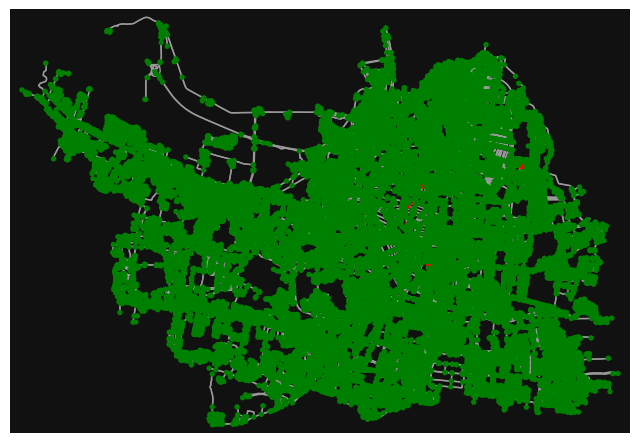

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [290]:
# Melihat SPKLU sudah masuk ke graf
ox.plot_graph(G, node_color=["red" if n in spklu_nodes else "green" for n in G.nodes])

2. Input dan Persiapan Data

LOAD DATA 

In [7]:
# 📂 Load graph dari file Surabaya
graph_path = "../data/road_graph_weighted_surabaya.pkl"
try:
    with open(graph_path, 'rb') as f:
        G = pickle.load(f)
    print("✅ Graf jalan Surabaya berhasil dimuat.")
except Exception as e:
    print(f"❌ Gagal memuat graf jalan Surabaya: {e}")
    G = None

✅ Graf jalan Surabaya berhasil dimuat.


In [8]:
import math

def haversine(lon1, lat1, lon2, lat2):
    R = 6371.0  # radius bumi dalam km
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
   
    return distance

# Fungsi untuk mencari node terdekat dengan menggunakan OSMnx
def find_nearest_node_osmnx(G, coord):
    return ox.distance.nearest_nodes(G, X=coord[1], Y=coord[0])

# Fungsi untuk memeriksa apakah konektor tersedia pada node SPKLU
def is_connector_available(node_id, connector_type):
    if node_id in G.nodes:
        available_connectors = G.nodes[node_id].get('available_connectors', [])
        if connector_type in available_connectors:
            return True
    return False


In [9]:
def validate_input():
    print("\n--- Proses 1: Validasi Input ---")
    
    geolocator = Nominatim(user_agent="ev_route_finder")
    start_address = input("Masukkan lokasi awal: ")
    end_address = input("Masukkan lokasi tujuan: ")

    print(f"\nMencari koordinat untuk lokasi awal: {start_address}")
    print(f"Mencari koordinat untuk lokasi tujuan: {end_address}")

    start_location = geolocator.geocode(start_address)
    end_location = geolocator.geocode(end_address)

    if not start_location or not end_location:
        print("❌ Lokasi tidak ditemukan. Pastikan alamat dimasukkan dengan benar.")
        exit()

    # Menampilkan hasil geocoding
    print(f"✅ Lokasi awal ditemukan: {start_location.latitude}, {start_location.longitude}")
    print(f"✅ Lokasi tujuan ditemukan: {end_location.latitude}, {end_location.longitude}")

    start_coords = (start_location.latitude, start_location.longitude)
    end_coords = (end_location.latitude, end_location.longitude)

    # Temukan node terdekat di graf menggunakan OSMnx
    start_node = find_nearest_node_osmnx(G, start_coords)
    end_node = find_nearest_node_osmnx(G, end_coords)

    if not start_node or not end_node:
        print("❌ Node terdekat tidak ditemukan. Pastikan alamat berada dalam jangkauan graf.")
        exit()
        
    # Pilihan kapasitas baterai
    battery_options = {
        1: {"model": "Wuling Air EV Standard Range", "capacity": 17.3, "range": 200},
        2: {"model": "Wuling Air EV Long Range", "capacity": 31.9, "range": 300},
        3: {"model": "Wuling BinguoEV Premium Range", "capacity": 37.9, "range": 410},
        4: {"model": "Wuling BinguoEV Long Range", "capacity": 31.9, "range": 333},
        5: {"model": "Wuling Cloud EV", "capacity": 50.6, "range": 460}
    }

    print("\nPilih kapasitas baterai mobil:")
    for key, value in battery_options.items():
        print(f"{key}. {value['model']} (Jarak Tempuh: {value['range']} km, Kapasitas: {value['capacity']} kWh)")

    try:
        battery_choice = int(input("Masukkan pilihan kapasitas baterai (1-5): "))
        selected_battery = battery_options.get(battery_choice)

        if not selected_battery:
            raise ValueError("❌ Pilihan tidak valid.")
    except ValueError as e:
        print(e)
        exit()

    # Input kapasitas baterai dan level baterai saat ini
    try:
        battery_capacity = selected_battery['capacity']
        current_battery_percent = float(input("Masukkan persentase baterai saat ini (0-100): "))

        if not (0 <= current_battery_percent <= 100):
            raise ValueError("❌ Persentase baterai harus antara 0 dan 100.")
        
        connector_type = input("Masukkan jenis konektor (CCS2, AC Type 2, GBT, CHAdeMO): ")

        if connector_type not in ['CCS2', 'AC Type 2', 'GBT', 'CHAdeMO']:
            raise ValueError("❌ Jenis konektor tidak valid. Pilih antara: CCS2, AC Type 2, GBT, CHAdeMO.")
        
        current_energy = (current_battery_percent / 100.0) * battery_capacity
    except ValueError as e:
        print(e)
        exit()

    # Output informasi input pengguna
    print("\n--- Informasi Input ---")
    print(f"Lokasi awal: {start_address} → Koordinat: {start_coords}")
    print(f"Lokasi tujuan: {end_address} → Koordinat: {end_coords}")
    print(f"Node awal terdekat: {start_node}")
    print(f"Node tujuan terdekat: {end_node}")
    print(f"Jenis konektor: {connector_type}")
    print(f"Kapasitas baterai mobil: {selected_battery['model']} - {selected_battery['capacity']} kWh")
    
    return start_coords, end_coords, start_node, end_node, current_energy, battery_capacity, connector_type

# Memanggil fungsi validasi input
start_coords, end_coords, start_node, end_node, current_energy, battery_capacity, connector_type = validate_input()


--- Proses 1: Validasi Input ---

Mencari koordinat untuk lokasi awal: universitas ciputra surabaya
Mencari koordinat untuk lokasi tujuan: stasiun gubeng surabaya
✅ Lokasi awal ditemukan: -7.2865722, 112.6320953
✅ Lokasi tujuan ditemukan: -7.2663625, 112.7514528

Pilih kapasitas baterai mobil:
1. Wuling Air EV Standard Range (Jarak Tempuh: 200 km, Kapasitas: 17.3 kWh)
2. Wuling Air EV Long Range (Jarak Tempuh: 300 km, Kapasitas: 31.9 kWh)
3. Wuling BinguoEV Premium Range (Jarak Tempuh: 410 km, Kapasitas: 37.9 kWh)
4. Wuling BinguoEV Long Range (Jarak Tempuh: 333 km, Kapasitas: 31.9 kWh)
5. Wuling Cloud EV (Jarak Tempuh: 460 km, Kapasitas: 50.6 kWh)

--- Informasi Input ---
Lokasi awal: universitas ciputra surabaya → Koordinat: (-7.2865722, 112.6320953)
Lokasi tujuan: stasiun gubeng surabaya → Koordinat: (-7.2663625, 112.7514528)
Node awal terdekat: 3224672310
Node tujuan terdekat: 2304458307
Jenis konektor: CCS2
Kapasitas baterai mobil: Wuling Air EV Long Range - 31.9 kWh


In [10]:
# --- Proses 2: Menghitung Jarak dan Energi yang Dibutuhkan ---

# Fungsi untuk menghitung energi yang dibutuhkan
def calculate_energy_required(distance, consumption_rate):
    # Konsumsi energi per kilometer
    return consumption_rate * distance  # kWh per kilometer berdasarkan kapasitas mobil

# Proses perhitungan jarak dan energi
def process_calculations(start_coords, end_coords, current_energy, battery_capacity):
    print("\n--- Proses 2: Menghitung Jarak dan Energi ---")
    
    # Menghitung jarak antara lokasi awal dan tujuan
    distance = haversine(start_coords[1], start_coords[0], end_coords[1], end_coords[0])  # Longitude di index [1], Latitude di index [0]
    print(f"Jarak antara lokasi awal dan tujuan: {distance:.2f} km")
    
    # Konsumsi energi kendaraan (kWh per km) - Sesuaikan dengan kapasitas mobil
    energy_consumption_per_km = 0.2  # Asumsikan kendaraan menggunakan energi 0.2 kWh/km standar
    consumption_rate = energy_consumption_per_km  # Gunakan nilai konsumsi energi langsung tanpa mengalikan dengan kapasitas baterai
    required_energy = calculate_energy_required(distance, consumption_rate)
    print(f"Jumlah energi yang dibutuhkan untuk perjalanan: {required_energy:.2f} kWh")

    # Cek apakah energi yang tersedia cukup untuk perjalanan
    if current_energy < required_energy:
        print("❌ Energi tidak cukup untuk perjalanan. Mengisi ulang baterai diperlukan.")
    else:
        print("✅ Energi cukup untuk perjalanan.")
    
    return distance, required_energy

# Proses perhitungan
distance, required_energy = process_calculations(start_coords, end_coords, current_energy, battery_capacity)


--- Proses 2: Menghitung Jarak dan Energi ---
Jarak antara lokasi awal dan tujuan: 13.36 km
Jumlah energi yang dibutuhkan untuk perjalanan: 2.67 kWh
✅ Energi cukup untuk perjalanan.


In [11]:
# --- Matriks Jarak ---
def build_distance_matrix(valid_nodes, graph):
    distance_matrix = np.zeros((len(valid_nodes), len(valid_nodes)))
    node_to_index = {node: index for index, node in enumerate(valid_nodes)}  # Pemetaan node ke indeks
    for i, start_node in enumerate(valid_nodes):
        for j, end_node in enumerate(valid_nodes):
            if i != j:
                try:
                    # Mencari jarak terpendek antara start_node dan end_node dalam graph
                    path = nx.shortest_path(graph, start_node, end_node, weight='distance')
                    distance = nx.shortest_path_length(graph, start_node, end_node, weight='distance')
                    distance_matrix[i][j] = distance
                except nx.NetworkXNoPath:
                    distance_matrix[i][j] = float('inf')  # Tidak ada jalur yang tersedia
    return distance_matrix, node_to_index

# --- Menambahkan lebih banyak node ke valid_nodes ---
valid_nodes = [start_node, end_node]  # Mulai dengan start_node dan end_node

# Jika ada node SPKLU, tambahkan ke valid_nodes
spklu_nodes = [node_id for node_id, data in G.nodes(data=True) if data.get("is_spklu")]  # Misalnya, node SPKLU
valid_nodes.extend(spklu_nodes)  # Menambahkan SPKLU ke dalam valid_nodes jika ada

# Membuat distance_matrix dengan valid_nodes yang lebih lengkap
distance_matrix, node_to_index = build_distance_matrix(valid_nodes, G)
print(f"✅ Matriks jarak dibangun dengan sukses, ukuran matriks: {len(distance_matrix)}x{len(distance_matrix[0])}")

# --- Summary Output ---
print("\n--- Ringkasan Matriks Jarak ---")
print(f"✅ Valid nodes ({len(valid_nodes)}): {valid_nodes}")
print("✅ Distance matrix:")
print(distance_matrix)

✅ Matriks jarak dibangun dengan sukses, ukuran matriks: 11x11

--- Ringkasan Matriks Jarak ---
✅ Valid nodes (11): [3224672310, 2304458307, 335624177, 413886956, 1283196012, 1640240882, 2124921874, 3260847073, 3522371774, 4222366095, 5572466108]
✅ Distance matrix:
[[ 0.         16.3155196  15.35295941 14.03181702 17.15982658 15.77524248
  14.91327498 15.3564861  16.72295535 15.94696927 22.03352157]
 [16.46499122  0.          2.77763115  2.36680761  1.28125831  1.68399956
   1.61746444  3.45051784  0.76991612  1.85572635  6.45331811]
 [16.15323632  2.34145549  0.          3.85036077  1.80686717  1.87158566
   2.94145314  5.61764409  2.46355541  1.76240842  6.76434641]
 [14.09818361  2.36586294  3.77452847  0.          3.39041791  1.9529727
   0.96361832  2.59045722  2.77329868  2.12469949  8.49063914]
 [17.53555013  1.12124768  2.09286515  3.43736652  0.          1.78552058
   2.68802335  4.57176553  1.84047503  1.67634334  6.58255442]
 [16.12582181  1.87287894  2.80901856  2.02763819  


Episode 1/1000 - Unvisited Nodes: {2304458307, 3224672310}
current_node: 3224672310, remaining_energy: 9.569999999999999 kWh, total_distance: 0 km
State yang dikirimkan ke DQN: current_node = 3224672310, remaining_energy = 9.569999999999999 kWh, total_distance = 0 km, battery_capacity = 31.9 kWh
State array: [3.22467231e+09 9.57000000e+00 0.00000000e+00 3.19000000e+01]
State yang dikirimkan ke DQN: current_node = 3224672310, remaining_energy = 9.569999999999999 kWh, total_distance = 0 km, battery_capacity = 31.9 kWh
State array: [3.22467231e+09 9.57000000e+00 0.00000000e+00 3.19000000e+01]
Exploration: Action chosen: 2304458307
Aksi yang dipilih: 2304458307
State yang dikirimkan ke DQN: current_node = 2304458307, remaining_energy = 6.3068960790463215 kWh, total_distance = 16.315519604768383 km, battery_capacity = 31.9 kWh
State array: [2.30445831e+09 6.30689608e+00 1.63155196e+01 3.19000000e+01]

Episode 1/1000 - Unvisited Nodes: {3224672310}
current_node: 2304458307, remaining_energy

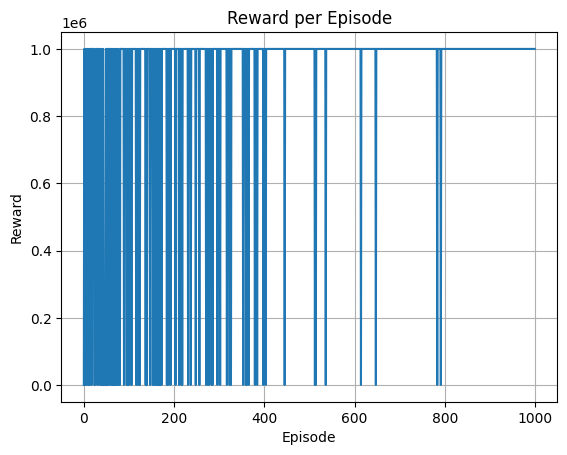


=== Ringkasan Hasil DQN ===
Total jarak: 16.32 km
Total energi yang digunakan: 3.19 kWh
Node awal: 3224672310
Node akhir: 2304458307
Jumlah SPKLU yang ditemukan di jalur: 0
Reward: 1000201.00
✅ Daya cukup sampai tujuan tanpa perlu ke SPKLU
❌ Tidak ada SPKLU di jalur yang ditemukan


In [ ]:
import matplotlib.pyplot as plt

import streamlit as st
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- Fungsi yang diperlukan untuk DQN dan alur Anda ---
# Pastikan semua kelas DQN, ReplayBuffer, dan EVRouteAgent sudah didefinisikan sebelumnya.

# Fungsi untuk menampilkan hasil
def display_results_streamlit(best_routes, total_distance, cumulative_reward, start_coords, spklu_nodes, current_energy, battery_capacity):
    st.subheader("=== Ringkasan Hasil DQN ===")
    st.write(f"Total jarak: {total_distance:.2f} km")
    st.write(f"Total energi yang digunakan: {current_energy - (battery_capacity * 0.2):.2f} kWh")
    st.write(f"Node awal: {start_node}")
    st.write(f"Node akhir: {end_node}")
    
    # Cek SPKLU dalam rute
    spklu_nodes_in_route = [node for node in best_routes if G.nodes[node].get("is_spklu") == True]
    st.write(f"Jumlah SPKLU yang ditemukan di jalur: {len(spklu_nodes_in_route)}")
    st.write(f"Reward: {cumulative_reward:.2f}")

    if current_energy > total_distance * 0.2:
        st.write("✅ Daya cukup sampai tujuan tanpa perlu ke SPKLU")
    else:
        st.write("❌ Daya tidak cukup, harus mampir ke SPKLU")

    if spklu_nodes_in_route:
        st.write(f"SPKLU yang ditemukan di jalur: {spklu_nodes_in_route}")
        first_spklu_node = spklu_nodes_in_route[0]
        first_spklu_coords = [G.nodes[first_spklu_node]['y'], G.nodes[first_spklu_node]['x']]
        distance_to_first_spklu = haversine(start_coords[1], start_coords[0], first_spklu_coords[1], first_spklu_coords[0])
        st.write(f"Jarak ke SPKLU pertama: {distance_to_first_spklu:.2f} km")
    else:
        st.write("❌ Tidak ada SPKLU di jalur yang ditemukan")

# Fungsi untuk melatih agen dan menampilkan hasil di Streamlit
def train_ev_route_agent_streamlit(agent, num_episodes=1000, batch_size=32, update_target_every=10):
    best_routes = []
    best_total_distance = float('inf')
    final_route = []
    final_reward = 0
    rewards_per_episode = []

    for episode in range(num_episodes):
        total_distance = 0
        cumulative_reward = 0
        unvisited_nodes = set([start_node, end_node])
        current_node = start_node
        remaining_energy = current_energy
        route = [current_node]

        while unvisited_nodes:
            state = get_state(current_node, remaining_energy, total_distance, battery_capacity)
            action = agent.choose_action(current_node, remaining_energy, total_distance, node_to_index, unvisited_nodes)

            if action not in unvisited_nodes:
                break

            distance = distance_matrix[node_to_index[current_node]][node_to_index[action]]
            if distance == float('inf'):
                break

            total_distance += distance
            remaining_energy -= distance * 0.2

            reward = max(10 / (distance + 1e-5), 1)
            reward += 100
            cumulative_reward += reward

            next_state = get_state(action, remaining_energy, total_distance, battery_capacity)
            agent.store_experience(state, action, reward, next_state, False)

            current_node = action
            route.append(action)
            unvisited_nodes.remove(action)

        agent.train(batch_size=batch_size)

        if episode % update_target_every == 0:
            agent.update_target_model()

        if total_distance < best_total_distance:
            best_total_distance = total_distance
            best_routes = route
            final_reward = cumulative_reward

        rewards_per_episode.append(cumulative_reward)

        # Menampilkan status training setiap 100 episode
        if episode % 100 == 0:
            st.write(f"Episode {episode + 1}/{num_episodes} - Total Distance: {total_distance:.2f} km - Reward: {cumulative_reward:.2f} - Epsilon: {agent.epsilon:.4f}")

    # Visualisasi grafik reward per episode
    st.subheader("Reward per Episode")
    plt.plot(range(len(rewards_per_episode)), rewards_per_episode)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward per Episode')
    plt.grid(True)
    st.pyplot()  # Menampilkan plot dalam Streamlit

    return best_routes, best_total_distance, final_reward

# --- Streamlit UI Setup ---
st.title("DQN EV Route Optimization")

# Menambahkan input untuk parameter training jika diperlukan
num_episodes = st.slider("Number of Episodes", min_value=100, max_value=1000, value=1000)
batch_size = st.slider("Batch Size", min_value=16, max_value=128, value=32)

# Inisialisasi agen
num_actions = len(distance_matrix[0])
agent = EVRouteAgent(num_actions=num_actions)

# Menjalankan training dan menampilkan hasil di Streamlit
best_routes, total_distance, cumulative_reward = train_ev_route_agent_streamlit(agent, num_episodes=num_episodes, batch_size=batch_size)

# Tampilkan hasil setelah training
display_results_streamlit(best_routes, total_distance, cumulative_reward, start_coords, spklu_nodes, current_energy, battery_capacity)


In [19]:
# Simpan model setelah pelatihan
def save_model(agent, file_path):
    agent.model.save(file_path)
    print(f"Model disimpan di {file_path}")
# Menyimpan model
agent.model.save('dqn_model.keras')



In [ ]:

# Buat peta dasar
m = folium.Map(location=start_coords, zoom_start=13)

# Marker lokasi awal
folium.Marker(
    start_coords,
    popup=f"<b>Lokasi Awal</b><br>{start_address}",
    icon=folium.Icon(color="red", icon="play", prefix="fa")
).add_to(m)

# Marker lokasi tujuan
folium.Marker(
    end_coords,
    popup=f"<b>Lokasi Tujuan</b><br>{end_address}",
    icon=folium.Icon(color="blue", icon="flag", prefix="fa")
).add_to(m)

# Marker SPKLU (ikon petir)
for spklu_id, spklu_info in spklu_nodes.items():
    if 'x' in spklu_info and 'y' in spklu_info:
        popup_text = f"""
        <b>SPKLU ID:</b> {spklu_id}<br>
        <b>Konektor:</b> {', '.join(spklu_info.get('available_connectors', []))}
        """
        folium.Marker(
            [spklu_info['y'], spklu_info['x']],
            popup=popup_text,
            icon=folium.Icon(color="green", icon="bolt", prefix="fa")
        ).add_to(m)

# --- Rute dari DQN ---
routes = [best_routes]
total_distance_km_dqn = 0
color_palette = cm.get_cmap('rainbow', len(routes))

for i, route in enumerate(routes):
    rgba_color = color_palette(i / len(routes))
    route_color = mcolors.to_hex(rgba_color)

    for j in range(len(route) - 1):
        a, b = route[j], route[j + 1]
        if a in G.nodes and b in G.nodes and G.has_edge(a, b):
            coords = [(G.nodes[a]['y'], G.nodes[a]['x']), (G.nodes[b]['y'], G.nodes[b]['x'])]
            distance = G[a][b].get('distance', 0)
            total_distance_km_dqn += distance / 1000

            folium.PolyLine(
                locations=coords,
                color=route_color,
                weight=4,
                opacity=0.9,
                dash_array="10, 10",  # Gaya putus-putus
                tooltip=f"Jarak: {distance:.0f} m"
            ).add_to(m)

# --- Tampilkan info total jarak ---
if best_routes:
    mid_idx = len(best_routes) // 2
    mid_node = best_routes[mid_idx]
    if mid_node in G.nodes:
        mid_coords = (G.nodes[mid_node]['y'], G.nodes[mid_node]['x'])
        folium.Marker(
            mid_coords,
            popup=f"<b>Total jarak DQN:</b><br>{total_distance_km_dqn:.2f} km",
            icon=folium.Icon(color="orange", icon="info-sign")
        ).add_to(m)

# --- Simpan sebagai HTML ---
m.save("dqn_ev_route_lastya.html")
print("🌈 Visualisasi rute DQN berhasil disimpan sebagai 'dqn_ev_route_beautified.html'")


🌈 Visualisasi rute DQN berhasil disimpan sebagai 'dqn_ev_route_beautified.html'


/var/folders/bd/1gfn4wvd2yj_rjzsdjyq1g940000gn/T/ipykernel_20035/1696563427.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap('rainbow', len(routes))


In [14]:
# Shortest path
import folium
import pickle
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import osmnx as ox
import networkx as nx
from geopy.geocoders import Nominatim

# 📂 Load graph dari file Surabaya
with open("../data/road_graph_weighted_surabaya.pkl", "rb") as f:
    G = pickle.load(f)

print("✅ Graf jalan Surabaya berhasil dimuat.")

# --- Mengambil SPKLU yang sudah ada dalam graf ---
spklu_nodes = {node_id: data for node_id, data in G.nodes(data=True) if data.get("is_spklu")}
print(f"Total SPKLU dalam graf: {len(spklu_nodes)}")

# --- Lokasi Awal dan Tujuan ---
start_address = "Universitas Ciputra Surabaya"
end_address = "tunjungan plaza"

# Ambil koordinat lokasi menggunakan geopy
geolocator = Nominatim(user_agent="ev_route_finder")
start_location = geolocator.geocode(start_address)
end_location = geolocator.geocode(end_address)

if not start_location or not end_location:
    print("❌ Lokasi tidak ditemukan.")
    exit()

start_coords = (start_location.latitude, start_location.longitude)
end_coords = (end_location.latitude, end_location.longitude)

# --- Temukan node terdekat ---
start_node = ox.nearest_nodes(G, X=start_coords[1], Y=start_coords[0])
end_node = ox.nearest_nodes(G, X=end_coords[1], Y=end_coords[0])
print(f"Start node: {start_node}, End node: {end_node}")

# --- Cari shortest path berdasarkan jarak ---
try:
    shortest_path = nx.shortest_path(G, source=start_node, target=end_node, weight='distance')
    print(f"📍 Jumlah node dalam shortest path: {len(shortest_path)}")
except nx.NetworkXNoPath:
    print("❌ Tidak ditemukan jalur dari start ke end.")
    exit()

# --- Visualisasi Peta ---
m = folium.Map(location=start_coords, zoom_start=13)

# Marker lokasi awal dan tujuan
folium.Marker(start_coords, popup=f"Awal: {start_address}", icon=folium.Icon(color="red")).add_to(m)
folium.Marker(end_coords, popup=f"Tujuan: {end_address}", icon=folium.Icon(color="blue")).add_to(m)

# Marker SPKLU
for spklu_id, spklu_info in spklu_nodes.items():
    folium.Marker(
        [spklu_info['y'], spklu_info['x']], 
        popup=f"SPKLU {spklu_id} - Konektor: {', '.join(spklu_info.get('available_connectors', []))}",
        icon=folium.Icon(color="green", icon="cloud")
    ).add_to(m)

# --- Gambar shortest path ---
edge_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in shortest_path]
folium.PolyLine(edge_coords, color="orange", weight=5, opacity=0.9, tooltip="Shortest Path").add_to(m)

# --- Simpan peta ---
m.save("shortest.html")
print("✅ Peta dengan shortest path disimpan sebagai 'shortest_path_only_map.html'")


✅ Graf jalan Surabaya berhasil dimuat.
Total SPKLU dalam graf: 9
Start node: 3224672310, End node: 5579915086
📍 Jumlah node dalam shortest path: 170
✅ Peta dengan shortest path disimpan sebagai 'shortest_path_only_map.html'


Fungsi-fungsi PERHITUNGAN

In [33]:
# # Menghitung jarak antara dua koordinat menggunakan Haversine formula
# import math

# def haversine(lon1, lat1, lon2, lat2):
#     R = 6371.0  # radius bumi dalam km
#     lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
#     dlon = lon2 - lon1
#     dlat = lat2 - lat1

#     a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
#     c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
#     distance = R * c
   
#     return distance


# # # Fungsi untuk mencari node terdekat berdasarkan koordinat
# # def find_nearest_node(G, coord):
# #     min_dist = float('inf')
# #     nearest_node = None
# #     for node, data in G.nodes(data=True):
# #         if 'x' in data and 'y' in data:
# #             node_coord = (data['y'], data['x'])
# #             dist = haversine(coord[1], coord[0], node_coord[1], node_coord[0])
# #             if dist < min_dist:
# #                 min_dist = dist
# #                 nearest_node = node
# #     return nearest_node

# # # Fungsi untuk memeriksa apakah konektor tersedia pada node SPKLU
# # def is_connector_available(node_id, connector_type):
# #     if node_id in G.nodes:
# #         available_connectors = G.nodes[node_id].get('available_connectors', [])
# #         if connector_type in available_connectors:
# #             return True
# #     return False

# # Fungsi untuk mencari node terdekat dengan menggunakan OSMnx
# def find_nearest_node_osmnx(G, coord):
#     return ox.distance.nearest_nodes(G, X=coord[1], Y=coord[0])

# # Fungsi untuk memeriksa apakah konektor tersedia pada node SPKLU
# def is_connector_available(node_id, connector_type):
#     if node_id in G.nodes:
#         available_connectors = G.nodes[node_id].get('available_connectors', [])
#         if connector_type in available_connectors:
#             return True
#     return False


Fungsi validasi input (Proses 1)

In [34]:
# import math  # Pastikan modul math sudah diimpor
# from math import radians, sin, cos, sqrt, atan2  # Pastikan untuk menggunakan radians

# # def validate_input():
#     print("\n--- Proses 1: Validasi Input ---")
    
#     geolocator = Nominatim(user_agent="ev_route_finder")
#     start_address = input("Masukkan lokasi awal: ")
#     end_address = input("Masukkan lokasi tujuan: ")

#     print(f"\nMencari koordinat untuk lokasi awal: {start_address}")
#     print(f"Mencari koordinat untuk lokasi tujuan: {end_address}")

#     start_location = geolocator.geocode(start_address)
#     end_location = geolocator.geocode(end_address)

#     if not start_location or not end_location:
#         print("❌ Lokasi tidak ditemukan. Pastikan alamat dimasukkan dengan benar.")
#         exit()

#     # Menampilkan hasil geocoding
#     print(f"✅ Lokasi awal ditemukan: {start_location.latitude}, {start_location.longitude}")
#     print(f"✅ Lokasi tujuan ditemukan: {end_location.latitude}, {end_location.longitude}")

#     start_coords = (start_location.latitude, start_location.longitude)
#     end_coords = (end_location.latitude, end_location.longitude)

#     # Temukan node terdekat di graf berdasarkan koordinat
#     start_node = find_nearest_node(G, start_coords)
#     end_node = find_nearest_node(G, end_coords)

#     if not start_node or not end_node:
#         print("❌ Node terdekat tidak ditemukan. Pastikan alamat berada dalam jangkauan graf.")
#         exit()
        
#     # Pilihan kapasitas baterai
#     battery_options = {
#         1: {"model": "Wuling Air EV Standard Range", "capacity": 17.3, "range": 200},
#         2: {"model": "Wuling Air EV Long Range", "capacity": 31.9, "range": 300},
#         3: {"model": "Wuling BinguoEV Premium Range", "capacity": 37.9, "range": 410},
#         4: {"model": "Wuling BinguoEV Long Range", "capacity": 31.9, "range": 333},
#         5: {"model": "Wuling Cloud EV", "capacity": 50.6, "range": 460}
#     }

#     print("\nPilih kapasitas baterai mobil:")
#     for key, value in battery_options.items():
#         print(f"{key}. {value['model']} (Jarak Tempuh: {value['range']} km, Kapasitas: {value['capacity']} kWh)")

#     try:
#         battery_choice = int(input("Masukkan pilihan kapasitas baterai (1-5): "))
#         selected_battery = battery_options.get(battery_choice)

#         if not selected_battery:
#             raise ValueError("❌ Pilihan tidak valid.")
#     except ValueError as e:
#         print(e)
#         exit()

#     # Input kapasitas baterai dan level baterai saat ini
#     try:
#         battery_capacity = selected_battery['capacity']
#         current_battery_percent = float(input("Masukkan persentase baterai saat ini (0-100): "))

#         if not (0 <= current_battery_percent <= 100):
#             raise ValueError("❌ Persentase baterai harus antara 0 dan 100.")
        
#         connector_type = input("Masukkan jenis konektor (CCS2, AC Type 2, GBT, CHAdeMO): ")

#         if connector_type not in ['CCS2', 'AC Type 2', 'GBT', 'CHAdeMO']:
#             raise ValueError("❌ Jenis konektor tidak valid. Pilih antara: CCS2, AC Type 2, GBT, CHAdeMO.")
        
#         current_energy = (current_battery_percent / 100.0) * battery_capacity
#     except ValueError as e:
#         print(e)
#         exit()

#     # Output informasi input pengguna
#     print("\n--- Informasi Input ---")
#     print(f"Lokasi awal: {start_address} → Koordinat: {start_coords}")
#     print(f"Lokasi tujuan: {end_address} → Koordinat: {end_coords}")
#     print(f"Node awal terdekat: {start_node}")
#     print(f"Node tujuan terdekat: {end_node}")
#     print(f"Jenis konektor: {connector_type}")
#     print(f"Kapasitas baterai mobil: {selected_battery['model']} - {selected_battery['capacity']} kWh")
    
#     return start_coords, end_coords, start_node, end_node, current_energy, battery_capacity, connector_type

# # Memanggil fungsi validasi input
# start_coords, end_coords, start_node, end_node, current_energy, battery_capacity, connector_type = validate_input()


# def validate_input():
#     print("\n--- Proses 1: Validasi Input ---")
    
#     geolocator = Nominatim(user_agent="ev_route_finder")
#     start_address = input("Masukkan lokasi awal: ")
#     end_address = input("Masukkan lokasi tujuan: ")

#     print(f"\nMencari koordinat untuk lokasi awal: {start_address}")
#     print(f"Mencari koordinat untuk lokasi tujuan: {end_address}")

#     start_location = geolocator.geocode(start_address)
#     end_location = geolocator.geocode(end_address)

#     if not start_location or not end_location:
#         print("❌ Lokasi tidak ditemukan. Pastikan alamat dimasukkan dengan benar.")
#         exit()

#     # Menampilkan hasil geocoding
#     print(f"✅ Lokasi awal ditemukan: {start_location.latitude}, {start_location.longitude}")
#     print(f"✅ Lokasi tujuan ditemukan: {end_location.latitude}, {end_location.longitude}")

#     start_coords = (start_location.latitude, start_location.longitude)
#     end_coords = (end_location.latitude, end_location.longitude)

#     # Temukan node terdekat di graf menggunakan OSMnx
#     start_node = find_nearest_node_osmnx(G, start_coords)
#     end_node = find_nearest_node_osmnx(G, end_coords)

#     if not start_node or not end_node:
#         print("❌ Node terdekat tidak ditemukan. Pastikan alamat berada dalam jangkauan graf.")
#         exit()
        
#     # Pilihan kapasitas baterai
#     battery_options = {
#         1: {"model": "Wuling Air EV Standard Range", "capacity": 17.3, "range": 200},
#         2: {"model": "Wuling Air EV Long Range", "capacity": 31.9, "range": 300},
#         3: {"model": "Wuling BinguoEV Premium Range", "capacity": 37.9, "range": 410},
#         4: {"model": "Wuling BinguoEV Long Range", "capacity": 31.9, "range": 333},
#         5: {"model": "Wuling Cloud EV", "capacity": 50.6, "range": 460}
#     }

#     print("\nPilih kapasitas baterai mobil:")
#     for key, value in battery_options.items():
#         print(f"{key}. {value['model']} (Jarak Tempuh: {value['range']} km, Kapasitas: {value['capacity']} kWh)")

#     try:
#         battery_choice = int(input("Masukkan pilihan kapasitas baterai (1-5): "))
#         selected_battery = battery_options.get(battery_choice)

#         if not selected_battery:
#             raise ValueError("❌ Pilihan tidak valid.")
#     except ValueError as e:
#         print(e)
#         exit()

#     # Input kapasitas baterai dan level baterai saat ini
#     try:
#         battery_capacity = selected_battery['capacity']
#         current_battery_percent = float(input("Masukkan persentase baterai saat ini (0-100): "))

#         if not (0 <= current_battery_percent <= 100):
#             raise ValueError("❌ Persentase baterai harus antara 0 dan 100.")
        
#         connector_type = input("Masukkan jenis konektor (CCS2, AC Type 2, GBT, CHAdeMO): ")

#         if connector_type not in ['CCS2', 'AC Type 2', 'GBT', 'CHAdeMO']:
#             raise ValueError("❌ Jenis konektor tidak valid. Pilih antara: CCS2, AC Type 2, GBT, CHAdeMO.")
        
#         current_energy = (current_battery_percent / 100.0) * battery_capacity
#     except ValueError as e:
#         print(e)
#         exit()

#     # Output informasi input pengguna
#     print("\n--- Informasi Input ---")
#     print(f"Lokasi awal: {start_address} → Koordinat: {start_coords}")
#     print(f"Lokasi tujuan: {end_address} → Koordinat: {end_coords}")
#     print(f"Node awal terdekat: {start_node}")
#     print(f"Node tujuan terdekat: {end_node}")
#     print(f"Jenis konektor: {connector_type}")
#     print(f"Kapasitas baterai mobil: {selected_battery['model']} - {selected_battery['capacity']} kWh")
    
#     return start_coords, end_coords, start_node, end_node, current_energy, battery_capacity, connector_type

# # Memanggil fungsi validasi input
# start_coords, end_coords, start_node, end_node, current_energy, battery_capacity, connector_type = validate_input()

Proses 2: Menghitung Jarak dan Energi yang Dibutuhkan

In [35]:
# # --- Proses 2: Menghitung Jarak dan Energi yang Dibutuhkan ---

# # Fungsi untuk menghitung energi yang dibutuhkan
# def calculate_energy_required(distance, consumption_rate):
#     # Konsumsi energi per kilometer
#     return consumption_rate * distance  # kWh per kilometer berdasarkan kapasitas mobil

# # Proses perhitungan jarak dan energi
# def process_calculations(start_coords, end_coords, current_energy, battery_capacity):
#     print("\n--- Proses 2: Menghitung Jarak dan Energi ---")
    
#     # Menghitung jarak antara lokasi awal dan tujuan
#     distance = haversine(start_coords[1], start_coords[0], end_coords[1], end_coords[0])  # Longitude di index [1], Latitude di index [0]
#     print(f"Jarak antara lokasi awal dan tujuan: {distance:.2f} km")
    
#     # Konsumsi energi kendaraan (kWh per km) - Sesuaikan dengan kapasitas mobil
#     energy_consumption_per_km = 0.2  # Asumsikan kendaraan menggunakan energi 0.2 kWh/km standar
#     consumption_rate = energy_consumption_per_km  # Gunakan nilai konsumsi energi langsung tanpa mengalikan dengan kapasitas baterai
#     required_energy = calculate_energy_required(distance, consumption_rate)
#     print(f"Jumlah energi yang dibutuhkan untuk perjalanan: {required_energy:.2f} kWh")

#     # Cek apakah energi yang tersedia cukup untuk perjalanan
#     if current_energy < required_energy:
#         print("❌ Energi tidak cukup untuk perjalanan. Mengisi ulang baterai diperlukan.")
#     else:
#         print("✅ Energi cukup untuk perjalanan.")
    
#     return distance, required_energy

# # Proses perhitungan
# distance, required_energy = process_calculations(start_coords, end_coords, current_energy, battery_capacity)

In [36]:
# print(f"Current Energy: {current_energy} kWh")
# print(f"Energy Needed: {required_energy} kWh")
# print(f"Remaining Energy: {current_energy - required_energy}")


Proses 3: Pelatihan DQN untuk Memilih Rute

Langkah 1: Menyusun Matriks Jarak

In [37]:
# # --- Matriks Jarak ---
# def build_distance_matrix(valid_nodes, graph):
#     distance_matrix = np.zeros((len(valid_nodes), len(valid_nodes)))
#     node_to_index = {node: index for index, node in enumerate(valid_nodes)}  # Pemetaan node ke indeks
#     for i, start_node in enumerate(valid_nodes):
#         for j, end_node in enumerate(valid_nodes):
#             if i != j:
#                 try:
#                     # Mencari jarak terpendek antara start_node dan end_node dalam graph
#                     path = nx.shortest_path(graph, start_node, end_node, weight='distance')
#                     distance = nx.shortest_path_length(graph, start_node, end_node, weight='distance')
#                     distance_matrix[i][j] = distance
#                 except nx.NetworkXNoPath:
#                     distance_matrix[i][j] = float('inf')  # Tidak ada jalur yang tersedia
#     return distance_matrix, node_to_index

# # --- Menambahkan lebih banyak node ke valid_nodes ---
# valid_nodes = [start_node, end_node]  # Mulai dengan start_node dan end_node

# # Jika ada node SPKLU, tambahkan ke valid_nodes
# spklu_nodes = [node_id for node_id, data in G.nodes(data=True) if data.get("is_spklu")]  # Misalnya, node SPKLU
# valid_nodes.extend(spklu_nodes)  # Menambahkan SPKLU ke dalam valid_nodes jika ada

# # Membuat distance_matrix dengan valid_nodes yang lebih lengkap
# distance_matrix, node_to_index = build_distance_matrix(valid_nodes, G)
# print(f"✅ Matriks jarak dibangun dengan sukses, ukuran matriks: {len(distance_matrix)}x{len(distance_matrix[0])}")

# # --- Summary Output ---
# print("\n--- Ringkasan Matriks Jarak ---")
# print(f"✅ Valid nodes ({len(valid_nodes)}): {valid_nodes}")
# print("✅ Distance matrix:")
# print(distance_matrix)


In [38]:
# # --- Model DQN ---
# class DQN(tf.keras.Model):
#     def __init__(self, num_actions):
#         super(DQN, self).__init__()
#         self.fc1 = tf.keras.layers.Dense(256, activation='relu')
#         self.fc2 = tf.keras.layers.Dense(256, activation='relu')
#         self.fc3 = tf.keras.layers.Dense(128, activation='relu')
#         self.output_layer = tf.keras.layers.Dense(num_actions, activation=None)

#     def call(self, inputs):
#         x = self.fc1(inputs)
#         x = self.fc2(x)
#         x = self.fc3(x)
#         return self.output_layer(x)

# # --- Replay Buffer ---
# class ReplayBuffer:
#     def __init__(self, buffer_size=10000):
#         self.buffer = deque(maxlen=buffer_size)

#     def add(self, experience):
#         self.buffer.append(experience)

#     def sample(self, batch_size):
#         return random.sample(self.buffer, batch_size)

#     def __len__(self):
#         return len(self.buffer)
    
# # --- DQN Agent ---
# class EVRouteAgent:
#     def __init__(self, num_actions, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, learning_rate=0.001):
#         self.num_actions = num_actions
#         self.gamma = gamma
#         self.epsilon = epsilon
#         self.epsilon_decay = epsilon_decay
#         self.epsilon_min = epsilon_min
#         self.model = DQN(num_actions)
#         self.target_model = DQN(num_actions)
#         self.optimizer = tf.keras.optimizers.Adam(learning_rate)
#         self.replay_buffer = ReplayBuffer()
#         self.update_target_model()  # Ensure that the target model is initialized with the same weights as the model
        
#     def update_target_model(self):
#         # Copy the weights from the model to the target model
#         self.target_model.set_weights(self.model.get_weights())

#     def choose_action(self, current_node, remaining_energy, total_distance, node_to_index, unvisited_nodes):
#         state = get_state(current_node, remaining_energy, total_distance, battery_capacity)
#         state_tensor = tf.convert_to_tensor([state], dtype=tf.float32)

#         if np.random.rand() < self.epsilon:
#             # Exploration: Choose a random action
#             action = np.random.choice(list(unvisited_nodes))
#             print(f"Exploration: Action chosen: {action}")
#         else:
#             # Exploitation: Choose the best action based on Q-values
#             q_values = self.model(state_tensor).numpy()[0]
#             masked_q_values = np.full_like(q_values, -np.inf)
#             for node in unvisited_nodes:
#                 node_index = node_to_index.get(node)
#                 if node_index is not None:
#                     masked_q_values[node_index] = q_values[node_index]
            
#             action_index = np.argmax(masked_q_values)
#             action = list(node_to_index.keys())[action_index]
#             print(f"Exploitation: Action chosen: {action} (Node Index: {action_index})")

#         return action

#     def store_experience(self, state, action, reward, next_state, done):
#         state = np.atleast_2d(state)
#         next_state = np.atleast_2d(next_state)
#         self.replay_buffer.add((state, action, reward, next_state, done))

#     def train(self, batch_size=32):
#         if len(self.replay_buffer) < batch_size:
#             return
#         batch = self.replay_buffer.sample(batch_size)
#         states, actions, rewards, next_states, dones = zip(*batch)
#         states = tf.convert_to_tensor(np.array(states).squeeze(axis=1), dtype=tf.float32)
#         next_states = tf.convert_to_tensor(np.array(next_states).squeeze(axis=1), dtype=tf.float32)
#         rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
#         actions = tf.convert_to_tensor(actions, dtype=tf.int32)
#         dones = tf.convert_to_tensor(dones, dtype=tf.float32)

#         next_q_values = self.target_model(next_states)
#         max_next_q_values = tf.reduce_max(next_q_values, axis=1)

#         targets = rewards + (1 - dones) * self.gamma * max_next_q_values

#         with tf.GradientTape() as tape:
#             q_values = self.model(states)
#             action_masks = tf.one_hot(actions, self.num_actions)
#             q_values = tf.reduce_sum(action_masks * q_values, axis=1)
#             loss = tf.keras.losses.MSE(targets, q_values)

#         gradients = tape.gradient(loss, self.model.trainable_variables)
#         self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

#         if self.epsilon > self.epsilon_min:
#             self.epsilon *= self.epsilon_decay

# # Fungsi untuk mendapatkan state yang diperlukan oleh DQN
# def get_state(current_node, remaining_energy, total_distance, battery_capacity):
#     state = np.array([current_node, remaining_energy, total_distance, battery_capacity])
    
#     # Debug: Print state before returning it
#     print(f"State yang dikirimkan ke DQN: current_node = {current_node}, "
#           f"remaining_energy = {remaining_energy} kWh, total_distance = {total_distance} km, "
#           f"battery_capacity = {battery_capacity} kWh")
#     print(f"State array: {state}")
    
#     return state

# # --- Proses Menampilkan Hasil DQN ---
# def display_results(best_routes, total_distance, cumulative_reward, start_coords, spklu_nodes, current_energy, battery_capacity):
#     print("\n=== Ringkasan Hasil DQN ===")
#     print(f"Total jarak: {total_distance:.2f} km")
#     print(f"Total energi yang digunakan: {current_energy - (battery_capacity * 0.2):.2f} kWh")
#     print(f"Node awal: {start_node}")
#     print(f"Node akhir: {end_node}")
    
#     # Cek SPKLU dalam rute
#     spklu_nodes_in_route = [node for node in best_routes if G.nodes[node].get("is_spklu") == True]
#     print(f"Jumlah SPKLU yang ditemukan di jalur: {len(spklu_nodes_in_route)}")
#     print(f"Reward: {cumulative_reward:.2f}")

#     if current_energy > total_distance * 0.2:
#         print("✅ Daya cukup sampai tujuan tanpa perlu ke SPKLU")
#     else:
#         print("❌ Daya tidak cukup, harus mampir ke SPKLU")

#     if spklu_nodes_in_route:
#         print(f"SPKLU yang ditemukan di jalur: {spklu_nodes_in_route}")
#         first_spklu_node = spklu_nodes_in_route[0]
#         first_spklu_coords = [G.nodes[first_spklu_node]['y'], G.nodes[first_spklu_node]['x']]
#         distance_to_first_spklu = haversine(start_coords[1], start_coords[0], first_spklu_coords[1], first_spklu_coords[0])
#         print(f"Jarak ke SPKLU pertama: {distance_to_first_spklu:.2f} km")
#     else:
#         print("❌ Tidak ada SPKLU di jalur yang ditemukan")



# # --- Latih Agen DQN ---
# def train_ev_route_agent(agent, num_episodes=1000, batch_size=32, update_target_every=10):
#     best_routes = []
#     best_total_distance = float('inf')
#     final_route = []
#     final_reward = 0
#     rewards_per_episode = []  # List to track rewards per episode (initialized here)

#     for episode in range(num_episodes):
#         total_distance = 0
#         cumulative_reward = 0
#         unvisited_nodes = set([start_node, end_node])
#         current_node = start_node
#         remaining_energy = current_energy
#         route = [current_node]

#         while unvisited_nodes:
#             print(f"\nEpisode {episode + 1}/{num_episodes} - Unvisited Nodes: {unvisited_nodes}")
#             print(f"current_node: {current_node}, remaining_energy: {remaining_energy} kWh, total_distance: {total_distance} km")

#             # Get the state representation of the current environment
#             state = get_state(current_node, remaining_energy, total_distance, battery_capacity)
#             action = agent.choose_action(current_node, remaining_energy, total_distance, node_to_index, unvisited_nodes)

#             print(f"Aksi yang dipilih: {action}")
#             if action not in unvisited_nodes:
#                 print(f"❌ Aksi {action} tidak valid!")
#                 break

#             distance = distance_matrix[node_to_index[current_node]][node_to_index[action]]
#             if distance == float('inf'):
#                 print(f"❌ Tidak ada jalur dari {current_node} ke {action}.")
#                 break

#             total_distance += distance
#             remaining_energy -= distance * 0.2

#             # Calculate reward: higher for shorter distances and penalize for longer distances
#             reward = max(10 / (distance + 1e-5), 1)
#             reward += 100
#             cumulative_reward += reward

#             # Get the next state after taking the action
#             next_state = get_state(action, remaining_energy, total_distance, battery_capacity)
#             agent.store_experience(state, action, reward, next_state, False)

#             current_node = action
#             route.append(action)
#             unvisited_nodes.remove(action)

#             if not unvisited_nodes:
#                 break

#         # Train the agent on the experience stored
#         agent.train(batch_size=batch_size)

#         # Periodically update the target model
#         if episode % update_target_every == 0:
#             agent.update_target_model()

#         # Update the best route if a shorter distance is found
#         if total_distance < best_total_distance:
#             best_total_distance = total_distance
#             best_routes = route
#             final_reward = cumulative_reward

#         # Store the cumulative reward for this episode
#         rewards_per_episode.append(cumulative_reward)

#         # Print training progress every 100 episodes
#         if episode % 100 == 0:
#             print(f"Episode {episode + 1}/{num_episodes} - Total Distance: {total_distance:.2f} km - Reward: {cumulative_reward:.2f} - Epsilon: {agent.epsilon:.4f}")

#     # Visualize the rewards per episode (this will work now)
#     plt.plot(range(len(rewards_per_episode)), rewards_per_episode)
#     plt.xlabel('Episode')
#     plt.ylabel('Reward')
#     plt.title('Reward per Episode')
#     plt.grid(True)
#     plt.show()

#     return best_routes, best_total_distance, final_reward


# # Inisialisasi agen
# num_actions = len(distance_matrix[0])
# agent = EVRouteAgent(num_actions=num_actions)

# # Latih agen dan simpan hasilnya
# best_routes, total_distance, cumulative_reward = train_ev_route_agent(agent)

# # Tampilkan hasil
# display_results(best_routes, total_distance, cumulative_reward, start_coords, spklu_nodes, current_energy, battery_capacity)


In [39]:
# print("🔎 Isi best_routes:", best_routes)
# print("📏 Panjang best_routes:", len(best_routes))


In [40]:
# import folium
# import matplotlib.cm as cm
# import matplotlib.colors as mcolors

# # Buat peta dasar
# m = folium.Map(location=start_coords, zoom_start=13)

# # Marker lokasi awal
# folium.Marker(
#     start_coords,
#     popup=f"<b>Lokasi Awal</b><br>{start_address}",
#     icon=folium.Icon(color="red", icon="play", prefix="fa")
# ).add_to(m)

# # Marker lokasi tujuan
# folium.Marker(
#     end_coords,
#     popup=f"<b>Lokasi Tujuan</b><br>{end_address}",
#     icon=folium.Icon(color="blue", icon="flag", prefix="fa")
# ).add_to(m)

# # Marker SPKLU (ikon petir)
# for spklu_id, spklu_info in spklu_nodes.items():
#     if 'x' in spklu_info and 'y' in spklu_info:
#         popup_text = f"""
#         <b>SPKLU ID:</b> {spklu_id}<br>
#         <b>Konektor:</b> {', '.join(spklu_info.get('available_connectors', []))}
#         """
#         folium.Marker(
#             [spklu_info['y'], spklu_info['x']],
#             popup=popup_text,
#             icon=folium.Icon(color="green", icon="bolt", prefix="fa")
#         ).add_to(m)

# # --- Rute dari DQN ---
# routes = [best_routes]
# total_distance_km_dqn = 0
# color_palette = cm.get_cmap('rainbow', len(routes))

# for i, route in enumerate(routes):
#     rgba_color = color_palette(i / len(routes))
#     route_color = mcolors.to_hex(rgba_color)

#     for j in range(len(route) - 1):
#         a, b = route[j], route[j + 1]
#         if a in G.nodes and b in G.nodes and G.has_edge(a, b):
#             coords = [(G.nodes[a]['y'], G.nodes[a]['x']), (G.nodes[b]['y'], G.nodes[b]['x'])]
#             distance = G[a][b].get('distance', 0)
#             total_distance_km_dqn += distance / 1000

#             folium.PolyLine(
#                 locations=coords,
#                 color=route_color,
#                 weight=4,
#                 opacity=0.9,
#                 dash_array="10, 10",  # Gaya putus-putus
#                 tooltip=f"Jarak: {distance:.0f} m"
#             ).add_to(m)

# # --- Tampilkan info total jarak ---
# if best_routes:
#     mid_idx = len(best_routes) // 2
#     mid_node = best_routes[mid_idx]
#     if mid_node in G.nodes:
#         mid_coords = (G.nodes[mid_node]['y'], G.nodes[mid_node]['x'])
#         folium.Marker(
#             mid_coords,
#             popup=f"<b>Total jarak DQN:</b><br>{total_distance_km_dqn:.2f} km",
#             icon=folium.Icon(color="orange", icon="info-sign")
#         ).add_to(m)

# # --- Simpan sebagai HTML ---
# m.save("dqn_ev_route_beautified.html")
# print("🌈 Visualisasi rute DQN berhasil disimpan sebagai 'dqn_ev_route_beautified.html'")


In [29]:
# # Shortest path
# import folium
# import pickle
# import matplotlib.colors as mcolors
# import matplotlib.cm as cm
# import osmnx as ox
# import networkx as nx
# from geopy.geocoders import Nominatim

# # 📂 Load graph dari file Surabaya
# with open("../data/road_graph_weighted_surabaya.pkl", "rb") as f:
#     G = pickle.load(f)

# print("✅ Graf jalan Surabaya berhasil dimuat.")

# # --- Mengambil SPKLU yang sudah ada dalam graf ---
# spklu_nodes = {node_id: data for node_id, data in G.nodes(data=True) if data.get("is_spklu")}
# print(f"Total SPKLU dalam graf: {len(spklu_nodes)}")

# # --- Lokasi Awal dan Tujuan ---
# start_address = "Universitas Ciputra Surabaya"
# end_address = "tunjungan plaza"

# # Ambil koordinat lokasi menggunakan geopy
# geolocator = Nominatim(user_agent="ev_route_finder")
# start_location = geolocator.geocode(start_address)
# end_location = geolocator.geocode(end_address)

# if not start_location or not end_location:
#     print("❌ Lokasi tidak ditemukan.")
#     exit()

# start_coords = (start_location.latitude, start_location.longitude)
# end_coords = (end_location.latitude, end_location.longitude)

# # --- Temukan node terdekat ---
# start_node = ox.nearest_nodes(G, X=start_coords[1], Y=start_coords[0])
# end_node = ox.nearest_nodes(G, X=end_coords[1], Y=end_coords[0])
# print(f"Start node: {start_node}, End node: {end_node}")

# # --- Cari shortest path berdasarkan jarak ---
# try:
#     shortest_path = nx.shortest_path(G, source=start_node, target=end_node, weight='distance')
#     print(f"📍 Jumlah node dalam shortest path: {len(shortest_path)}")
# except nx.NetworkXNoPath:
#     print("❌ Tidak ditemukan jalur dari start ke end.")
#     exit()

# # --- Visualisasi Peta ---
# m = folium.Map(location=start_coords, zoom_start=13)

# # Marker lokasi awal dan tujuan
# folium.Marker(start_coords, popup=f"Awal: {start_address}", icon=folium.Icon(color="red")).add_to(m)
# folium.Marker(end_coords, popup=f"Tujuan: {end_address}", icon=folium.Icon(color="blue")).add_to(m)

# # Marker SPKLU
# for spklu_id, spklu_info in spklu_nodes.items():
#     folium.Marker(
#         [spklu_info['y'], spklu_info['x']], 
#         popup=f"SPKLU {spklu_id} - Konektor: {', '.join(spklu_info.get('available_connectors', []))}",
#         icon=folium.Icon(color="green", icon="cloud")
#     ).add_to(m)

# # --- Gambar shortest path ---
# edge_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in shortest_path]
# folium.PolyLine(edge_coords, color="orange", weight=5, opacity=0.9, tooltip="Shortest Path").add_to(m)

# # --- Simpan peta ---
# m.save("shortest.html")
# print("✅ Peta dengan shortest path disimpan sebagai 'shortest_path_only_map.html'")
